In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
dataset_name = "W13_comb"

In [4]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (69486, 5173)
BES_numeric (69486, 4993)
var_type (5173, 13)
BES_non_numeric (69486, 125)
BES_reduced (69486, 2526)
BES_reduced_with_na (69486, 2526)
Wall time: 24min 15s


In [57]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [6]:
[x for x in BES_Panel.columns if "imm" in x.lower()]
# immigEcon, immigCultural 

# immigrationLevel SINGLE CHOICE W4W6
# immigContributeTake SCALE W7W8

# immigSelf W7W8W9W10W11W12W13
# immig<parties> W7W8W9W10W11W12W13

# immigrantsWelfareState DYNAMIC GRIDW1W2W3W4W7W8W10W11Topup
# immigEcon W1W2W3W4W6W7W8W10W11W13
# immigCultural W1W2W3W4W6W7W8W10W11W13

# changeImmig The level of immigration  W1W2W3W4W7W8W10W11
# changeImmigLab GRIDW1W2W3W4W7W10

# tryReduceImmig<parties> W4

# achieveReduceImmig<parties> W4W7W9W10W11W12

# responsibleImmig<parties> W1W2W3W4

# govtHandleImmig GRIDW1W2W3W4W7
# labHandleImmig GRID W1W2W3W4W7
 # <parties>Priorities_immig W1W2W3W4W6W9

# controlImmig W8W9W10W11W13

# effectsEUImmigration W7W8W10W11W13

['changeImmigW1',
 'responsibleImmigConservativesW1',
 'responsibleImmigLibDemsW1',
 'responsibleImmigLabourW1',
 'responsibleImmigScottishGovtW1',
 'responsibleImmigWelshGovtW1',
 'responsibleImmigNoneW1',
 'responsibleImmigDontKnowW1',
 'changeImmigLabW1',
 'immigEconW1',
 'immigCulturalW1',
 'immigrantsWelfareStateW1',
 'govtHandleImmigW1',
 'labHandleImmigW1',
 'conPriorities_immigW1',
 'labPriorities_immigW1',
 'ldPriorities_immigW1',
 'ukipPriorities_immigW1',
 'changeImmigW2',
 'responsibleImmigConservativesW2',
 'responsibleImmigLibDemsW2',
 'responsibleImmigLabourW2',
 'responsibleImmigScottishGovtW2',
 'responsibleImmigWelshGovtW2',
 'responsibleImmigNoneW2',
 'responsibleImmigDontKnowW2',
 'changeImmigLabW2',
 'immigrantsWelfareStateW2',
 'immigEconW2',
 'immigCulturalW2',
 'conPriorities_immigW2',
 'labPriorities_immigW2',
 'ldPriorities_immigW2',
 'ukipPriorities_immigW2',
 'govtHandleImmigW2',
 'labHandleImmigW2',
 'changeImmigW3',
 'responsibleImmigConservativesW3',
 're

In [ ]:
# euMIISmall -> immigration selected
# EUMIICategory -> immigration
['EUMIICategoryW7', 'euMIISmallW7', 'EUMIICategoryW8', 'euMIISmallW8']

In [24]:
[x for x in BES_reduced.columns if "eumii" in x.lower()]

[]

In [79]:
[x for x in BES_Panel.columns if "eumii" in x.lower()]

['EUMIICategoryW7', 'euMIISmallW7', 'EUMIICategoryW8', 'euMIISmallW8']

In [48]:
temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
eumii_vars = temp3

In [49]:
# euPriorityBalance SINGLE CHOICEW10W11W12W13
# Brexit priority: access to single market versus controlling immigration?

In [78]:
[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]

['miilabelW1',
 'miilabelW2',
 'miilabelW3',
 'miilabelW4',
 'miilabelW5',
 'miilabelW6']

In [1099]:
temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
mii_vars = temp3
# miilabel W1W2W3W4W5W6
#


In [98]:
# [x for x in BES_immig.columns if "discrim" in x]

In [1100]:
BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)

In [1101]:
Treatment = dataset_name + "_immigration"

In [1102]:
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [1103]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

In [1104]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
# n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 9.45 s


In [1105]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -184.3192984628109
number of iterations: 2


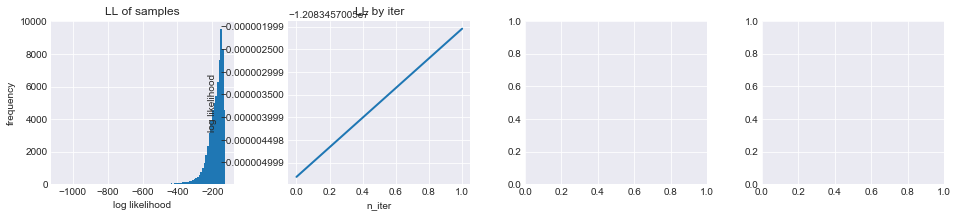

In [1106]:
display_pca_data(n_components, decomp, BES_std)

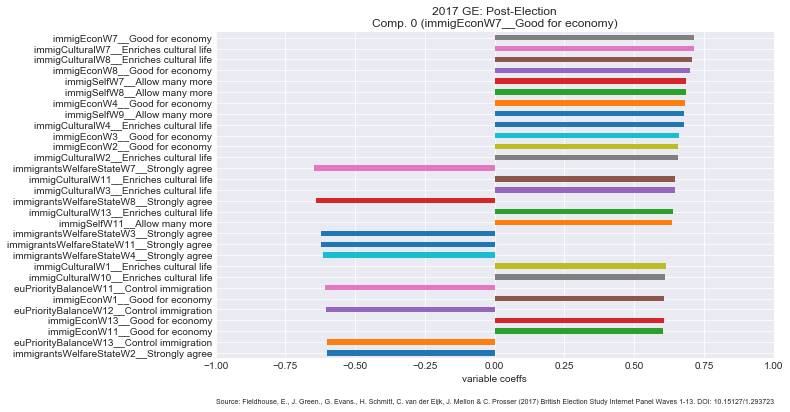

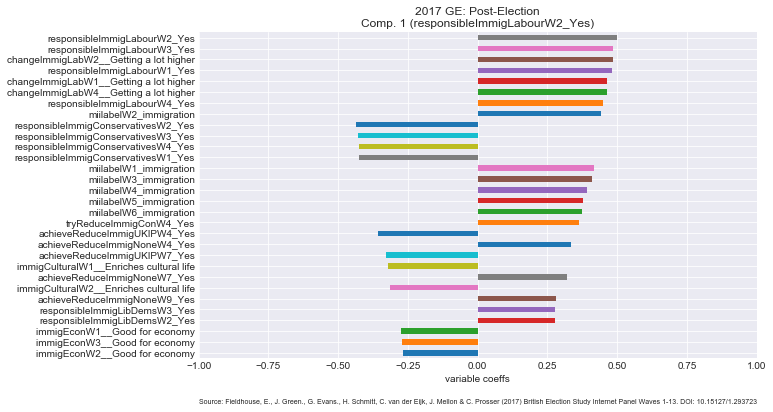

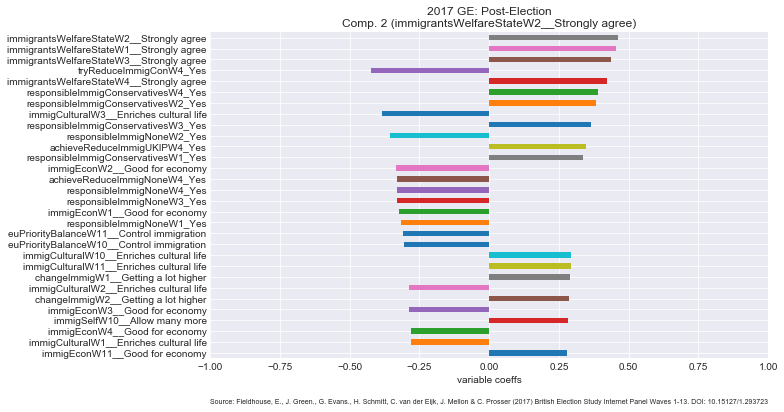

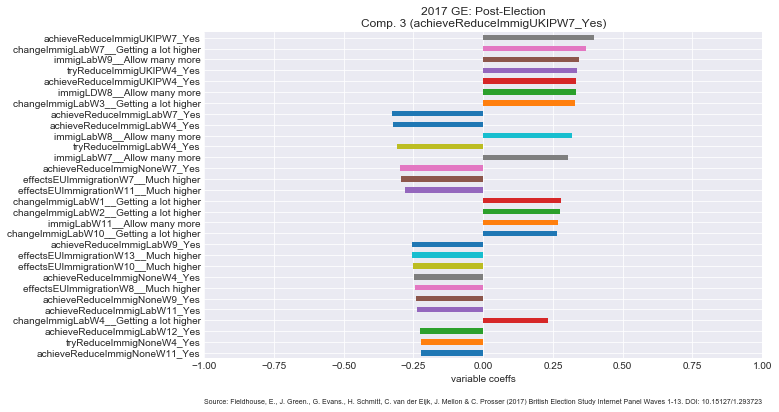

In [1107]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_immig.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

,noise_variance_
immigEconW2__Good for economy,0.382414
immigEconW7__Good for economy,0.387306
immigCulturalW2__Enriches cultural life,0.389836
immigEconW8__Good for economy,0.393393
immigCulturalW7__Enriches cultural life,0.401314
immigEconW4__Good for economy,0.402059
immigCulturalW11__Enriches cultural life,0.403007
immigCulturalW8__Enriches cultural life,0.404270
immigEconW3__Good for economy,0.410145
immigSelfW8__Allow many more,0.412613


,noise_variance_


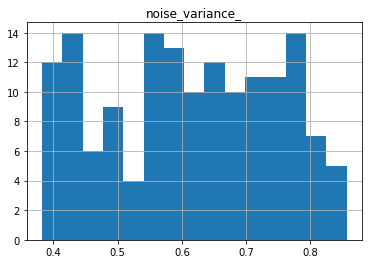

In [107]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

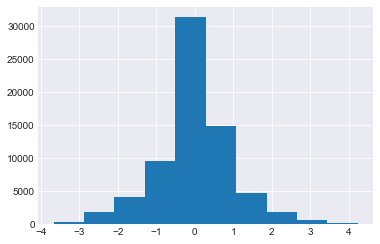

In [1108]:
BES_decomp[0].hist()

In [1]:
# BES_export_to_R = BES_immig.apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [ ]:
# try again with just the lowest noise variables
# immigEcon, immigCulturalm, immigSelf, immigrantsWelfareState, euPriorityBalance, 


In [169]:
BES_immig = BES_reduced[[x for x in BES_reduced.columns if re.match("immigEcon|immigCultural|immigSelf|immigrantsWelfareState|euPriorityBalance",x)]]

In [124]:
Treatment = dataset_name + "_immigration_narrower"

In [125]:
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [126]:
clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

In [127]:
%%time

n_components = BES_std.shape[1]

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_immig.index)

Wall time: 699 ms


In [128]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -37.503080085249834
number of iterations: 2


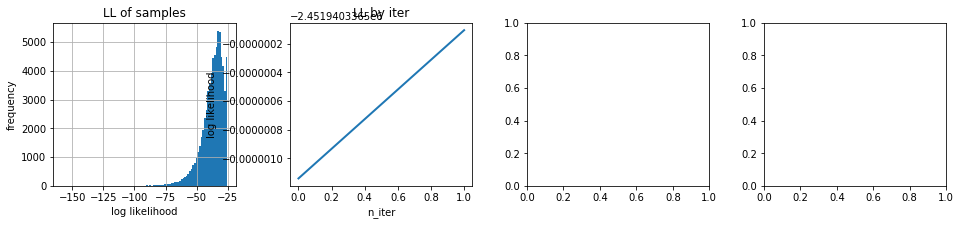

In [129]:
display_pca_data(n_components, decomp, BES_std)

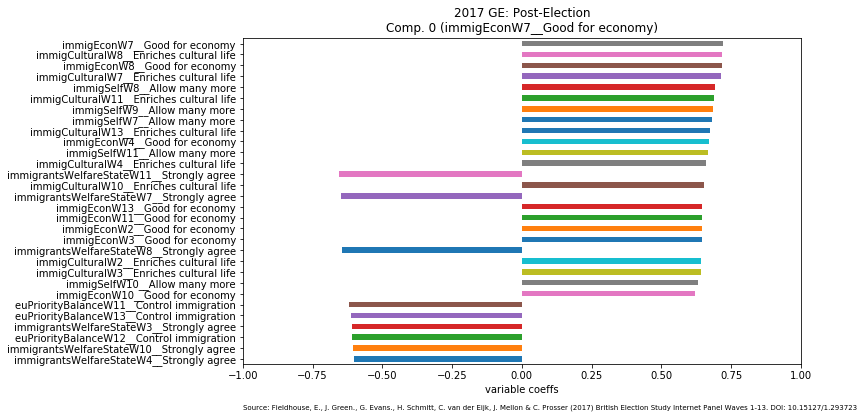

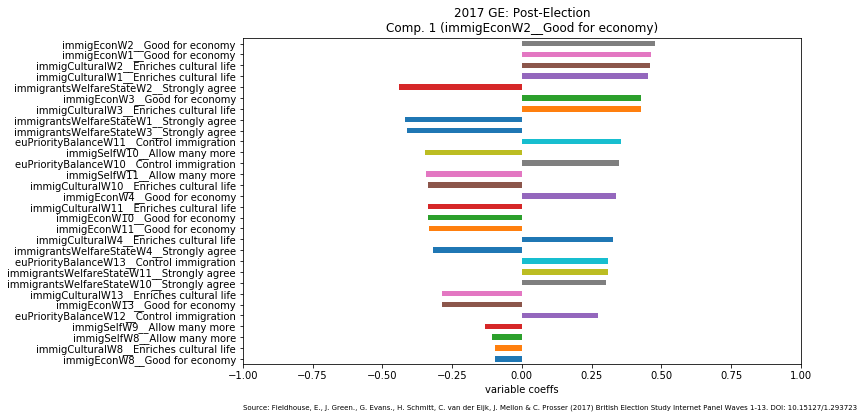

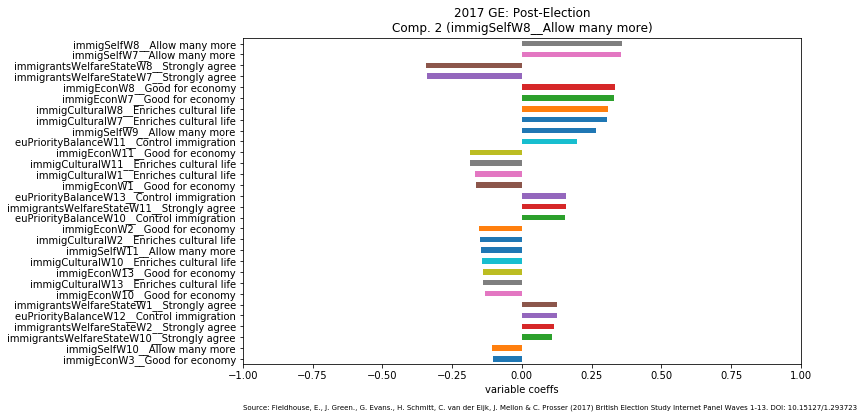

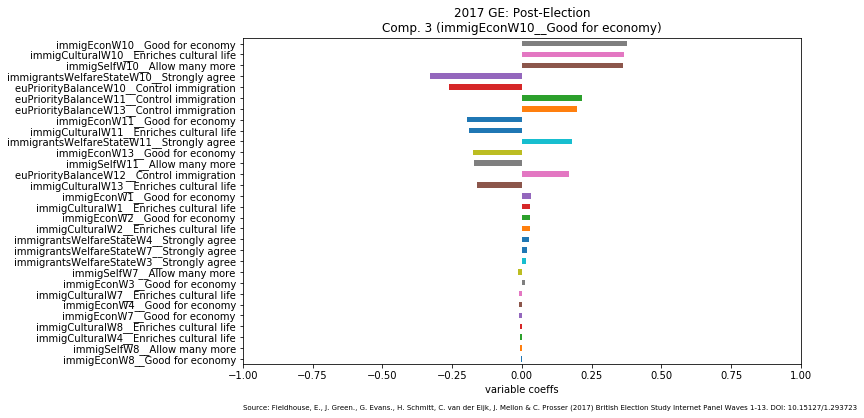

In [130]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_immig.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

,noise_variance_
immigEconW2__Good for economy,0.402361
immigCulturalW2__Enriches cultural life,0.418750
immigCulturalW11__Enriches cultural life,0.421834
immigCulturalW10__Enriches cultural life,0.430265
immigEconW8__Good for economy,0.431331
immigEconW7__Good for economy,0.433332
immigCulturalW8__Enriches cultural life,0.440764
immigEconW3__Good for economy,0.443343
immigCulturalW3__Enriches cultural life,0.445631
immigSelfW8__Allow many more,0.449151


,noise_variance_


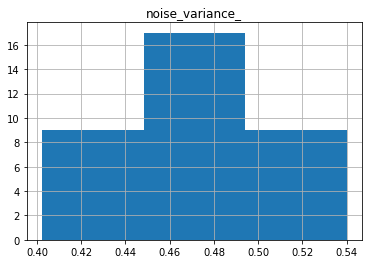

In [131]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [2]:
# BES_export_to_R = BES_immig.apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [143]:
hq_subset = BES_Panel[[x for x in BES_Panel.columns if re.match("immigEcon|immigCultural|immigSelf|immigrantsWelfareState|euPriorityBalance",x)]].notnull().sum(axis=1)>30

In [144]:
hq_subset.sum()

9138

In [3]:
# BES_export_to_R = BES_immig[hq_subset].apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [ ]:
# sankey diagram for imm_preferences?

In [6]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display, clear_output

In [7]:
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

In [8]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display, clear_output

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def make_sankey(BES, links, order, first_year, second_year, first_col, second_col,
                replace_dict, threshold, colour, fixed_order, scale, nodes, wt_col, groups, group_index):
    
    crosstab = pd.crosstab(index   = BES[ first_col  ],
                           columns = BES[ second_col ],
                           values  = BES[ wt_col ],
                           aggfunc = sum, dropna = False,
                           normalize=True)*scale

    if order == []: # initialise
        order = [ [[x+first_year]  for x in fixed_order] ]
    order.append( [[x+second_year] for x in fixed_order] ) # add new layer
    

    for col in crosstab.columns:
        if col not in replace_dict.keys():
            continue        
        second_party = replace_dict[ col ]
        for ind in crosstab[col].index:
            if ind not in replace_dict.keys():
                continue
            first_party = replace_dict[ ind ]
            
            if crosstab[col][ind]>threshold:
                if colour == []:
                    col_to_use = colourmap[first_party]
                else:
                    col_to_use = cmap[colour]
                
                node_id_first = first_party+first_year
                
                # add group if not already present
                if first_year not in group_index.keys():
                    group_index[first_year] = len(groups)
                    groups.append( {'id': first_year, 'title': first_year, 'nodes': []} )
                    
                if node_id_first not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_first, 'direction':'l'})
                    groups[group_index[first_year]]['nodes'].append(node_id_first)                    
                    
                node_id_second = second_party+second_year
                
                # add group if not already present
                if second_year not in group_index.keys():
                    group_index[second_year] = len(groups)
                    groups.append( {'id': second_year, 'title': second_year, 'nodes': []} )                
                
                if node_id_second not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_second, 'direction':'l'})
                    groups[group_index[second_year]]['nodes'].append(node_id_second)

                if colour ==[]:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use}
                else:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use,'type' : str(colour)}                    
                links.append(d)

    return links, order, nodes, groups, group_index

def sankify():
    colour = []
    order  = []
    links  = []
    # ["W7","W8","W9","W10","W11","W12","W13"]
    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}
    for pair_no in range(0,len(pairs)-1):


        (links, order, nodes, groups, group_index) = make_sankey(BES_Panel, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, fixed_order = base_order, scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale, layout=layout)
    return sankey

def sankify_init_col(): 
    # sankify with colour sets by initial choice

    colour = []
    order  = []
    links  = []

    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}

    for party in base_order:
        order  = []
        BES = BES_immig.loc[ BES_immig[immig_vars[0]]==party ]
        scale = 100 * BES.shape[0]/BES_immig.shape[0]
        colour = list(colourmap.values()).index( colourmap[replace_dict[party]] )    

        for pair_no in range(0,len(pairs)-1):

            (links, order, nodes, groups, group_index) = make_sankey(BES, links, order,
                                pairs[pair_no][0], pairs[pair_no+1][0],
                                pairs[pair_no][1], pairs[pair_no+1][1],
                                replace_dict, threshold, colour, fixed_order = base_order,
                                scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(layout=layout,links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale)
    return sankey

In [9]:
def sankify():
    colour = []
    order  = []
    links  = []
    # ["W7","W8","W9","W10","W11","W12","W13"]
    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}
    for pair_no in range(0,len(pairs)-1):


        (links, order, nodes, groups, group_index) = make_sankey(BES_Panel, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, fixed_order = base_order, scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale, layout=layout)
    return sankey

In [10]:
def sankify_init_col(): 
    # sankify with colour sets by initial choice

    colour = []
    order  = []
    links  = []

    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}

    for party in base_order:
        order  = []
        BES = BES_immig.loc[ BES_immig[immig_vars[0]]==party ]
        scale = 100 * BES.shape[0]/BES_immig.shape[0]
        colour = list(colourmap.values()).index( colourmap[replace_dict[party]] )    

        for pair_no in range(0,len(pairs)-1):

            (links, order, nodes, groups, group_index) = make_sankey(BES, links, order,
                                pairs[pair_no][0], pairs[pair_no+1][0],
                                pairs[pair_no][1], pairs[pair_no+1][1],
                                replace_dict, threshold, colour, fixed_order = base_order,
                                scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(layout=layout,links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale)
    return sankey

In [440]:
im_var = "immigSelf"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

wave_list = ["W7","W8","W9","W10","W11"]

In [441]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', "Don't k…

In [219]:
BES_Panel[[x for x in BES_Panel.columns if "immigEcon" in x]].notnull().sum()

immigEconW1     30333
immigEconW2     30240
immigEconW3     28108
immigEconW4     31440
immigEconW7     30895
immigEconW8     33502
immigEconW10    30319
immigEconW11    31014
immigEconW13    31197
dtype: int64

In [217]:
BES_Panel[[x for x in BES_Panel.columns if "immigSelf" in x]].notnull().sum()

immigSelfW7     30895
immigSelfW8     33502
immigSelfW9     30036
immigSelfW10    30319
immigSelfW11    31014
immigSelfW12     9008
immigSelfW13     1292
dtype: int64

In [14]:
im_var = "immigEcon"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories


In [17]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankey = sankify()
sankey.auto_save_png(BES_output_folder+os.sep+"leftRight_sankey.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Bad for economyW1', '2W1', '3W1', '4W1', '5W1', "D…

In [22]:
BES_output_folder

'../BES_analysis_output/'

In [26]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"immigEcon.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Bad for economyW1', '2W1', '3W1', '4W1', '5W1', '6…

In [530]:
wave_list = ["W1","W13"]

threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Undermines cultural lifeW1', '2W1', '3W1', '4W1', …

In [457]:
# now compared immigCultural
im_var = "immigCultural"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [458]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Undermines cultural lifeW1', '2W1', '3W1', '4W1', …

In [459]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Undermines cultural lifeW1', '2W1', '3W1', '4W1', …

In [534]:
# immigSelf W7W8W9W10W11W12W13
im_var = "immigSelf"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

# specific problem with the last two waves not overlapping the prior data!
wave_list = ['W7', 'W8', 'W9', 'W10', 'W11']

In [535]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', "Don't k…

In [536]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', '4W7', '…

In [106]:
#immigrantsWelfareState
im_var = "immigrantsWelfareState"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [107]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Strongly disagreeW1', 'DisagreeW1', 'Neither agree…

In [109]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
# sankify_init_col()
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"W13_comb_imm_corr"+os.sep+"immigrantsWelfareState.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Strongly disagreeW1', 'DisagreeW1', 'Neither agree…

In [557]:
# immigrationLevel
im_var = "immigrationLevel"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [558]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W4', 'title': 'W4', 'nodes': ['Decreased a lotW4', 'Decreased a littleW4', 'Left …

In [541]:
# immigContributeTake
# kind of a hassle because the categories are floats!

BES_Panel[[x for x in BES_Panel.columns if "immigContributeTake" in x]] = BES_Panel[[x for x in BES_Panel.columns if "immigContributeTake" in x]].apply(lambda x: x.cat.set_categories([str(x) for x in x.cat.categories]))



In [542]:
im_var = "immigContributeTake"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [543]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Pay more than they getW7', 'Get more than they pay…

In [110]:
# changeImmig
im_var = "changeImmig"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [115]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=180, right=180)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a little lowerW1', 'Staying about the same…

In [116]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=180, right=180)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"W13_comb_imm_corr"+os.sep+"changeImmig.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot lowerW1', 'Getting a little lowerW1'…

In [548]:
# changeImmig
im_var = "changeImmigLab"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [549]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot higherW1', 'Getting a little lowerW1…

In [550]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot lowerW1', 'Getting a little lowerW1'…

In [11]:
# controlImmig
im_var = "controlImmig"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [12]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W8', 'title': 'W8', 'nodes': ['No control at allW8', 'A little controlW8', 'Some …

In [13]:
threshold = 0.01
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=20
sankify_init_col()

SankeyWidget(groups=[{'id': 'W8', 'title': 'W8', 'nodes': ['No control at allW8', 'A little controlW8', 'Some …

In [ ]:
# asylum, eu, noneu, students, families

In [865]:
im_var = "asylumMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [866]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [867]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [862]:
im_var = "euMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [863]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [864]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [868]:
im_var = "noneuMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [869]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [870]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [871]:
im_var = "studentsMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [872]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [873]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [874]:
im_var = "familiesMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [875]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [876]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [ ]:
# effectsEUImmigration

In [566]:
im_var = "effectsEUImmigration"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [568]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Much lowerW7', 'LowerW7', 'About the sameW7', 'Muc…

In [569]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Much lowerW7', 'LowerW7', 'About the sameW7', 'Hig…

In [339]:
# euPriorityBalance

In [911]:
im_var = "euPriorityBalance"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [571]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W10', 'title': 'W10', 'nodes': ['Access to the single marketW10', '1W10', '2W10',…

In [912]:
threshold = 0.01
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W10', 'title': 'W10', 'nodes': ['Access to the single marketW10', '1W10', '2W10',…

In [345]:
# euMIISmall

In [348]:
# len(BES_immig[immig_vars[0]].cat.categories)

15

In [573]:
# euMIISmall
im_var = "euMIISmall"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [574]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['ImmigrationW7', 'EconomyW7', 'British/english iden…

In [ ]:
# EUMIICategory
# 54 categories - too many!

In [360]:
# miilabel
len(BES_immig[immig_vars[0]].cat.categories)

31

In [613]:
im_var = "miilabel"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars_minus_wt_col = immig_vars.copy()
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]

In [614]:
var_list=  []
for ind in range(0,len(immig_vars_minus_wt_col)):
    vc = BES_immig[immig_vars_minus_wt_col[ind]].value_counts()
    sig_var = vc[vc/vc.sum()>.03].index
    [var_list.append(x) for x in sig_var if x not in var_list]
var_list

['economy general',
 'immigration',
 "Don't know",
 'flooding',
 'unemployment',
 'poverty, living stds',
 'scot const',
 'europe',
 'nhs',
 'terrorism',
 'international probs',
 'services-spending',
 'social inequalities',
 'politics-neg']

In [616]:
ordered_by_freq = var_list
#BES_immig[immig_vars_minus_wt_col].stack().value_counts().index
temp = list(ordered_by_freq[0:12])
temp.append("Other")

for x in immig_vars_minus_wt_col:
    BES_immig[x] = BES_immig[x].cat.set_categories(temp)#.fillna("Other")

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [617]:
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories#.drop("Other")

In [618]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['unemploymentW1', 'economy generalW1', "Don't knowW…

In [619]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['economy generalW1', 'immigrationW1', "Don't knowW1…

In [ ]:
# 

In [81]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore"]

In [82]:
# np.empty( (10,10) )
number_of_waves = 13
imvars_by_waves = pd.DataFrame(np.full( ( len(imvar_list),number_of_waves), np.nan),
                  columns = ["W"+str(x) for x in range(1,number_of_waves+1)],
                  index = imvar_list ).T

In [83]:
#BES_Panel[immig_vars[0]].cat.codes.max()
max_range

10

In [84]:
for im_var in imvar_list:
    immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
    wave_list = [x.split(im_var)[1] for x in immig_vars]

    BES_immig = BES_Panel[immig_vars].replace("Don't know",np.nan).apply(lambda x: x.cat.codes).replace(-1,np.nan)
#     print(immig_vars, wave_list)
    max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
    print(immig_vars[0], max_range)
    for wave in wave_list:
        wt_new = "wt_new_"+wave
        wt_old = "wt_full_"+wave
        if wt_new in BES_Panel.columns:
            wt = BES_Panel[wt_new]
        else:
            wt = BES_Panel[wt_old]
        imvars_by_waves.loc[wave,im_var] = (BES_immig[im_var+wave].multiply(wt).mean())/max_range
        
    top_cat = BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore')[-1]
    imvars_by_waves.rename(index=str, columns={im_var: im_var + "_" + top_cat}, inplace=True)

imvars_by_waves

immigEconW1 6
immigCulturalW1 6
immigSelfW7 10
immigrationLevelW4 4
immigContributeTakeW7 6
immigrantsWelfareStateW1 4
controlImmigW8 4
effectsEUImmigrationW7 4
euPriorityBalanceW10 10
changeImmigW1 4
changeImmigLabW1 4
govtHandleImmigW1 4
labHandleImmigW1 4
asylumMoreW7 10
euMoreW7 10
noneuMoreW7 10
studentsMoreW7 10
familiesMoreW7 10


,immigEcon_Good for economy,immigCultural_Enriches cultural life,immigSelf_Allow many more,immigrationLevel_Increased a lot,immigContributeTake_Get more than they pay,immigrantsWelfareState_Strongly agree,controlImmig_Complete control,effectsEUImmigration_Much higher,euPriorityBalance_Control immigration,changeImmig_Getting a lot higher,changeImmigLab_Getting a lot higher,govtHandleImmig_Very well,labHandleImmig_Very well,asylumMore_Many more,euMore_Many more,noneuMore_Many more,studentsMore_Many more,familiesMore_Many more
W1,0.422969,0.405089,NaN,NaN,NaN,0.619937,NaN,NaN,NaN,0.744253,0.644485,0.380639,0.414651,NaN,NaN,NaN,NaN,NaN
W2,0.424609,0.409209,NaN,NaN,NaN,0.643482,NaN,NaN,NaN,0.731656,0.630306,0.342947,0.403055,NaN,NaN,NaN,NaN,NaN
W3,0.401930,0.393543,NaN,NaN,NaN,0.669404,NaN,NaN,NaN,0.762521,0.652189,0.273102,0.325407,NaN,NaN,NaN,NaN,NaN
W4,0.457556,0.432202,NaN,0.217151,NaN,0.620283,NaN,NaN,NaN,0.773037,0.643577,0.271421,0.348061,NaN,NaN,NaN,NaN,NaN
W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W6,NaN,NaN,NaN,0.235075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W7,0.450405,0.414961,0.294593,NaN,0.655993,0.631499,NaN,0.344286,NaN,0.793386,0.686475,0.239651,0.337831,0.312620,0.364955,0.316704,0.428538,0.372131
W8,0.461082,0.428667,0.297304,NaN,0.615500,0.624870,0.316654,0.338188,NaN,0.792248,NaN,NaN,NaN,0.318247,0.366504,0.338750,0.438382,0.362413
W9,NaN,NaN,0.314482,NaN,NaN,NaN,0.508021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W10,0.510847,0.458711,0.296479,NaN,NaN,0.550885,0.494319,0.365133,0.524150,0.656667,0.632893,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [881]:
len(set(imvars_by_waves.columns))

18

In [38]:
# imvars_by_waves.index[imvars_by_waves[imvar].isnull()]

Index(['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W9', 'W10', 'W11', 'W12'], dtype='object')

In [4]:
# # multiple line plot
# # create a color palette
# palette = plt.get_cmap('Set1')
# # style
# plt.style.use('seaborn-darkgrid')
# f = plt.figure(figsize=(10,10))

# num=1
# for imvar in imvars_by_waves.columns:
# #     plt.plot( imvars_by_waves.index, imvars_by_waves[imvar], color=palette(num))
#     g = sns.pointplot(imvars_by_waves.index, imvars_by_waves[imvar], color =cmap[num%(len(cmap))], label = imvar)
# # plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
# # plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
#     num=num+1
# g.legend();


In [50]:
wave_dates.loc[3]

Timestamp('2014-09-01 00:00:00')

In [86]:
wave_dates = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")
wave_dates = wave_dates.sort_index()
wave_dates = wave_dates["Date_Start"].apply(lambda x: pd.to_datetime(x))

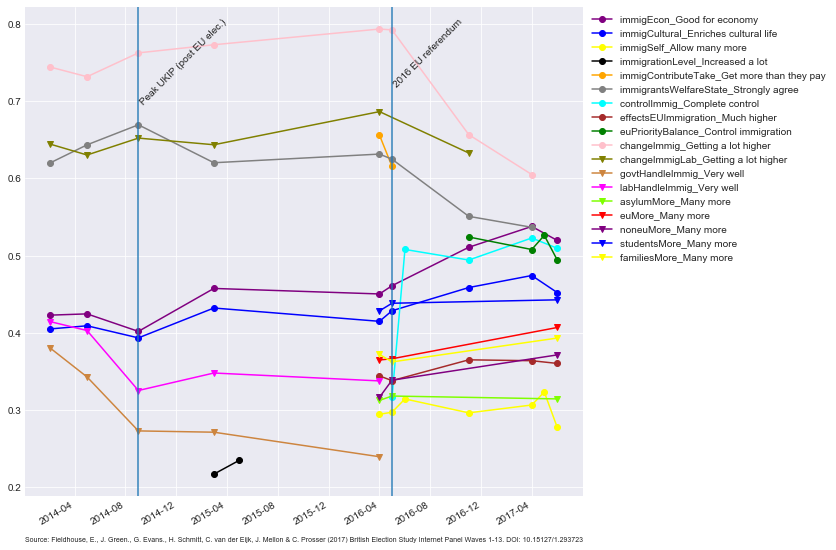

In [105]:
# date = pd.date_range("2017-03", freq="M", periods=15)
# count = np.random.rand(15,4)
# df1 = pd.DataFrame({"date":date, "count" : count[:,0]})
# df2 = pd.DataFrame({"date":date, "count" : count[:,1]+0.7})
# df3 = pd.DataFrame({"date":date, "count" : count[:,2]+2})

f, ax = plt.subplots(1, 1, figsize=(10,10))
# x_col='date'
# y_col = 'count'
num=1
for imvar in imvars_by_waves.columns:
    notnull_vals = imvars_by_waves[imvar].notnull()
    if num<=10:
        marker = 'o'
    else:
        marker = 'v'
    
    ax.plot_date(wave_dates.values[notnull_vals],
                 imvars_by_waves[imvar][notnull_vals],
                 color=cmap[num%len(cmap)],
                 label=imvar,
                 linestyle="-",
                 marker = marker)
    num = num +1
# ax.plot_date(wave_dates, df2["count"], color="red", label="B", linestyle="-")
# ax.plot_date(wave_dates, df3["count"], color="green", label="C", linestyle="-")

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# legend(loc="upper left", bbox_to_anchor=(1,1))

plt.gcf().autofmt_xdate()
plt.axvline(x=wave_dates.loc[3], alpha=.9)
plt.text(wave_dates.loc[3],.8,'Peak UKIP (post EU elec.)',rotation=45)
plt.axvline(x=wave_dates.loc[8], alpha=.9)
plt.text(wave_dates.loc[8],.8,'2016 EU referendum',rotation=45)

dataset_citation = "Source: " + manifest["Citation"].values[0]
plt.annotate(dataset_citation, (0,0), (0, -40),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  

Treatment = "W13_comb_imm_corr"
plt.savefig(BES_output_folder+ Treatment + os.sep + "Immigration_variables_by_waves.png",bbox_inches='tight');
plt.show()

In [ ]:
# LDA on voters who switched/stayed
# easier imm variables - immigEcon/immigCultural
# W8 -> W10

In [888]:
[ x for x in BES_Panel.columns if "immigEcon" in x]

['immigEconW1',
 'immigEconW2',
 'immigEconW3',
 'immigEconW4',
 'immigEconW7',
 'immigEconW8',
 'immigEconW10',
 'immigEconW11',
 'immigEconW13']

In [890]:
ImmBadW8 = (BES_Panel["immigEconW3"]=='Bad for economy') & (BES_Panel["immigEconW4"].notnull())
ChangedMind = BES_Panel[ImmBadW8]["immigEconW4"] != 'Bad for economy'
ChangedMind.value_counts()

False    3015
True     2047
Name: immigEconW4, dtype: int64

In [835]:
ImmBadW8 = (BES_Panel["immigEconW8"]=='Bad for economy') & (BES_Panel["immigEconW10"].notnull())
ChangedMind = BES_Panel[ImmBadW8]["immigEconW10"] != 'Bad for economy'
ChangedMind.value_counts()
# pretty distinct!

False    1773
True     1725
Name: immigEconW10, dtype: int64

In [903]:
BES_imm = BES_reduced[ImmBadW8]
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigEcon" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigCultural" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigSelf" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigrantsWelfareState" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "euPriorityBalance" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "UKIP" in x] , axis=1)

# immigrantsWelfareState, UKIP, euPriorityBalance, immigSelf
# weird stuff about passport variables!
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "passport" in x] , axis=1)

In [892]:
Treatment = "AntiImmigrantThaw"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [893]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [894]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_imm.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_imm.columns,
                             index   = BES_imm.index      )

In [898]:
%%time
n_components = BES_std.shape[1]
n_components = 1

decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std, ChangedMind)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_imm.index)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Wall time: 18.5 s


In [899]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "LinearDiscriminatAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

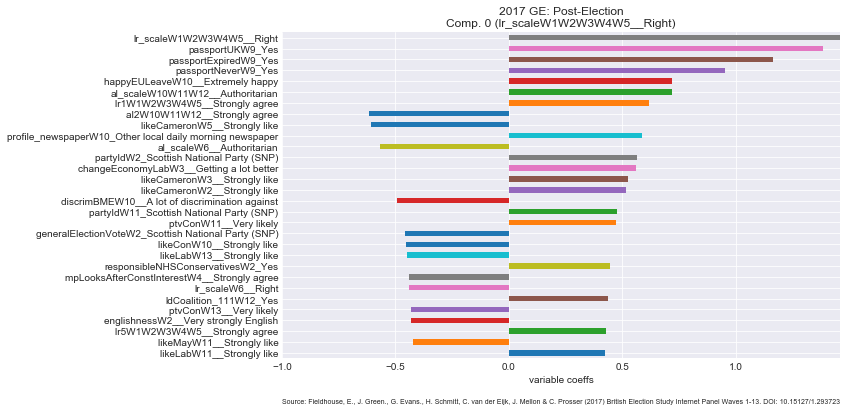

In [900]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_imm.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [901]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=100):
#     cols = X.columns
#     variables = np.arange(X.shape[1])
#     dropped=True
#     while dropped:
#         dropped=False
#         c = X[cols[variables]].values
#         vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
#             variables = np.delete(variables, maxloc)
#             dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X[cols[variables]]

In [5]:
gc.collect()

121

In [5]:
# imm_corr = BES_imm.corrwith(ChangedMind).sort_values().dropna()
# imm_corr

In [904]:
imm_corr = BES_imm.corrwith(ChangedMind).sort_values().dropna()
imm_corr

immigrantsWelfareStateW4__Strongly agree                          -0.337812
immigrantsWelfareStateW7__Strongly agree                          -0.224540
immigrantsWelfareStateW1__Strongly agree                          -0.220215
blackEqualityW1W2W3W4W5__Gone much too far                        -0.201304
blackEqualityW6W7W8W9__Gone much too far                          -0.196532
immigrantsWelfareStateW8__Strongly agree                          -0.188933
bestOnMIIW4_United Kingdom Independence Party (UKIP)              -0.184657
immigrantsWelfareStateW11__Strongly agree                         -0.177405
ukipGovTrustW5__ Would do a good job                              -0.173302
handleMIIUKIPW5__Very well                                        -0.167739
euRefVoteW4_Leave the EU                                          -0.167337
benefitsToMigrantsW7__Never                                       -0.165939
bestOnMIIW5_United Kingdom Independence Party (UKIP)              -0.165635
bestOnMIIW6_

In [ ]:
imm_corr[[x for x in imm_corr.index if "euRef" in x]]

In [ ]:
# realignment by social conservatism?

In [849]:
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x or "al_scale" in x] ].corr()

,immigEconW1__Good for economy,immigEconW2__Good for economy,immigEconW3__Good for economy,immigEconW4__Good for economy,immigEconW7__Good for economy,immigEconW8__Good for economy,immigEconW10__Good for economy,immigEconW11__Good for economy,immigEconW13__Good for economy,al_scaleW7W8W9__Authoritarian,al_scaleW6__Authoritarian,al_scaleW1W2W3W4W5__Authoritarian,al_scaleW10W11W12__Authoritarian,al_scaleW13__Authoritarian
immigEconW1__Good for economy,1.000000,0.695170,0.591612,0.533203,0.406240,0.356433,0.253667,0.266874,0.278760,-0.284692,-0.372838,-0.427680,-0.189378,-0.228255
immigEconW2__Good for economy,0.695170,1.000000,0.660060,0.587393,0.447572,0.397549,0.281049,0.296500,0.308631,-0.312424,-0.409137,-0.443589,-0.207430,-0.250529
immigEconW3__Good for economy,0.591612,0.660060,1.000000,0.623558,0.462452,0.405043,0.285870,0.306964,0.320517,-0.323991,-0.432566,-0.429213,-0.220789,-0.262039
immigEconW4__Good for economy,0.533203,0.587393,0.623558,1.000000,0.522405,0.460278,0.328776,0.349357,0.361689,-0.342958,-0.476817,-0.436678,-0.225291,-0.276387
immigEconW7__Good for economy,0.406240,0.447572,0.462452,0.522405,1.000000,0.618014,0.427058,0.440985,0.447992,-0.485004,-0.366924,-0.316674,-0.290938,-0.328597
immigEconW8__Good for economy,0.356433,0.397549,0.405043,0.460278,0.618014,1.000000,0.461033,0.471190,0.481693,-0.497568,-0.331176,-0.289487,-0.313879,-0.357873
immigEconW10__Good for economy,0.253667,0.281049,0.285870,0.328776,0.427058,0.461033,1.000000,0.514476,0.486080,-0.296985,-0.219517,-0.183047,-0.469514,-0.338184
immigEconW11__Good for economy,0.266874,0.296500,0.306964,0.349357,0.440985,0.471190,0.514476,1.000000,0.615729,-0.305137,-0.240821,-0.212922,-0.346258,-0.374339
immigEconW13__Good for economy,0.278760,0.308631,0.320517,0.361689,0.447992,0.481693,0.486080,0.615729,1.000000,-0.318521,-0.256709,-0.227272,-0.347480,-0.492688
al_scaleW7W8W9__Authoritarian,-0.284692,-0.312424,-0.323991,-0.342958,-0.485004,-0.497568,-0.296985,-0.305137,-0.318521,1.000000,0.538965,0.474406,0.472245,0.528087


In [861]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigCultural" in x] ].corrwith(al_lazy, drop=True)

immigCulturalW1__Enriches cultural life    -0.400835
immigCulturalW2__Enriches cultural life    -0.428178
immigCulturalW3__Enriches cultural life    -0.444245
immigCulturalW4__Enriches cultural life    -0.452386
immigCulturalW7__Enriches cultural life    -0.465251
immigCulturalW8__Enriches cultural life    -0.463512
immigCulturalW10__Enriches cultural life   -0.415242
immigCulturalW11__Enriches cultural life   -0.419797
immigCulturalW13__Enriches cultural life   -0.458830
dtype: float64

In [914]:
al2 = BES_reduced[ [x for x in BES_reduced if "al2" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigCultural" in x] ].corrwith(al2, drop=TImrue)

immigCulturalW1__Enriches cultural life    -0.357114
immigCulturalW2__Enriches cultural life    -0.380981
immigCulturalW3__Enriches cultural life    -0.406893
immigCulturalW4__Enriches cultural life    -0.406130
immigCulturalW7__Enriches cultural life    -0.416954
immigCulturalW8__Enriches cultural life    -0.417275
immigCulturalW10__Enriches cultural life   -0.377027
immigCulturalW11__Enriches cultural life   -0.387615
immigCulturalW13__Enriches cultural life   -0.424768
dtype: float64

In [913]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x] ].corrwith(al_lazy, drop=True)

immigEconW1__Good for economy    -0.398126
immigEconW2__Good for economy    -0.429514
immigEconW3__Good for economy    -0.440752
immigEconW4__Good for economy    -0.463793
immigEconW7__Good for economy    -0.472159
immigEconW8__Good for economy    -0.472411
immigEconW10__Good for economy   -0.394237
immigEconW11__Good for economy   -0.387586
immigEconW13__Good for economy   -0.429380
dtype: float64

In [915]:
al2 = BES_reduced[ [x for x in BES_reduced if "al2" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x] ].corrwith(al2, drop=True)

immigEconW1__Good for economy    -0.352247
immigEconW2__Good for economy    -0.383921
immigEconW3__Good for economy    -0.388108
immigEconW4__Good for economy    -0.419039
immigEconW7__Good for economy    -0.426494
immigEconW8__Good for economy    -0.423879
immigEconW10__Good for economy   -0.361115
immigEconW11__Good for economy   -0.350245
immigEconW13__Good for economy   -0.379244
dtype: float64

In [917]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigSelf" in x] ].corrwith(al_lazy, drop=True)

immigSelfW7__Allow many more    -0.488444
immigSelfW8__Allow many more    -0.490682
immigSelfW9__Allow many more    -0.479568
immigSelfW10__Allow many more   -0.438696
immigSelfW11__Allow many more   -0.448425
dtype: float64

In [916]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigrantsWelfareState" in x] ].corrwith(al_lazy, drop=True)

immigrantsWelfareStateW1__Strongly agree     0.431052
immigrantsWelfareStateW2__Strongly agree     0.460039
immigrantsWelfareStateW3__Strongly agree     0.494433
immigrantsWelfareStateW4__Strongly agree     0.498391
immigrantsWelfareStateW7__Strongly agree     0.502201
immigrantsWelfareStateW8__Strongly agree     0.498834
immigrantsWelfareStateW10__Strongly agree    0.454553
immigrantsWelfareStateW11__Strongly agree    0.465612
dtype: float64

In [918]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "controlImmig" in x] ].corrwith(al_lazy, drop=True)

controlImmigW9__Complete control     0.312930
controlImmigW10__Complete control    0.238897
controlImmigW11__Complete control    0.277157
controlImmigW13__Complete control    0.290759
dtype: float64

In [919]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "effectsEUImmigration" in x] ].corrwith(al_lazy, drop=True)

effectsEUImmigrationW7__Much higher    -0.154839
effectsEUImmigrationW8__Much higher    -0.197488
effectsEUImmigrationW10__Much higher   -0.160112
effectsEUImmigrationW11__Much higher   -0.189163
effectsEUImmigrationW13__Much higher   -0.187361
dtype: float64

In [920]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "euPriorityBalance" in x] ].corrwith(al_lazy, drop=True)

euPriorityBalanceW10__Control immigration    0.418034
euPriorityBalanceW11__Control immigration    0.430452
euPriorityBalanceW12__Control immigration    0.456111
euPriorityBalanceW13__Control immigration    0.466009
dtype: float64

In [923]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "changeImmig" in x] ].corrwith(al_lazy, drop=True)

changeImmigW1__Getting a lot higher        0.340271
changeImmigLabW1__Getting a lot higher     0.152314
changeImmigW2__Getting a lot higher        0.362287
changeImmigLabW2__Getting a lot higher     0.167442
changeImmigW3__Getting a lot higher        0.379347
changeImmigLabW3__Getting a lot higher     0.199524
changeImmigW4__Getting a lot higher        0.351209
changeImmigLabW4__Getting a lot higher     0.159036
changeImmigW7__Getting a lot higher        0.396410
changeImmigLabW7__Getting a lot higher     0.205500
changeImmigW8__Getting a lot higher        0.376823
changeImmigW10__Getting a lot higher       0.221959
changeImmigLabW10__Getting a lot higher    0.191727
changeImmigW11__Getting a lot higher       0.229182
dtype: float64

In [929]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "euMore" in x] ].corrwith(al_lazy, drop=True)

euMoreW7__Many more       -0.392712
noneuMoreW7__Many more    -0.363350
euMoreW8__Many more       -0.393122
noneuMoreW8__Many more    -0.334082
euMoreW13__Many more      -0.341576
noneuMoreW13__Many more   -0.319996
dtype: float64

In [925]:
all_corr = BES_reduced.corrwith(al_lazy, drop=True)

In [928]:
all_corr.drop([x for x in BES_reduced.columns if "al" in x]).sort_values()

immigSelfW8__Allow many more                     -0.490682
immigSelfW7__Allow many more                     -0.488444
asylumMoreW13__Many more                         -0.481439
asylumMoreW8__Many more                          -0.480110
asylumMoreW7__Many more                          -0.479987
immigSelfW9__Allow many more                     -0.479568
immigEconW8__Good for economy                    -0.472411
immigEconW7__Good for economy                    -0.472159
immigEconW4__Good for economy                    -0.463793
immigSelfW11__Allow many more                    -0.448425
immigEconW3__Good for economy                    -0.440752
immigSelfW10__Allow many more                    -0.438696
natSecuritySelfW13__Protect civil liberties      -0.435211
immigEconW2__Good for economy                    -0.429514
immigEconW13__Good for economy                   -0.429380
echrW8__Strongly agree                           -0.416940
immigrationLevelW6__Increased a lot              -0.4152

In [846]:
# add these later!
[x for x in BES_Panel.columns if "More" in x]

['asylumMoreW7',
 'euMoreW7',
 'noneuMoreW7',
 'studentsMoreW7',
 'familiesMoreW7',
 'asylumMoreW8',
 'euMoreW8',
 'noneuMoreW8',
 'studentsMoreW8',
 'familiesMoreW8',
 'asylumMoreW13',
 'euMoreW13',
 'noneuMoreW13',
 'studentsMoreW13',
 'familiesMoreW13']